In [1]:
import pandas as pd

### Clustering N-grams (2)

In [2]:
# File generated by Cluster_ngrams.py
df = pd.read_csv("tesis/lattice/cluster_file.csv", sep="\t", names=["cluster","num","id_table","id_file","file_name", "title", "id_table2", "header1", "header"], index_col=False )

In [3]:
df.head()

,cluster,num,id_table,id_file,file_name,title,id_table2,header1,header
0,"['date', 'user']",2,304725.1,304725,History of Facebook.html.bz2,History of Facebook,304725.1,"date,days later,monthly growth,users","date,day lat,month growth,user"
1,"['date', 'user']",2,513093.1,513093,Sketchfab.html.bz2,Sketchfab,513093.1,"date,users","date,user"
2,"['foreign cash', 'foreign cash total cash']",2,212901.1,212901,Companies of the United States with untaxed pr...,Companies of the United States with untaxed pr...,212901.1,"company,foreign cash,foreign cash total cash,...","compani,foreign cash,foreign cash total cash,t..."
3,"['foreign cash', 'foreign cash total cash']",2,551039.4,551039,Corporate tax in the United States.html.bz2,Corporate tax in the United States,551039.4,"company,foreign cash,foreign cash total cash,...","compani,foreign cash,foreign cash total cash,t..."
4,"['texa tech', 'west virginia']",1,702282.1,702282,1938 Sun Bowl.html.bz2,1938 Sun Bowl,702282.1,"statistics,texas tech,west virginia","statist,texa tech,west virginia"


Get groups by cluster (pair) and header to count. 

In [4]:
df_grouph=pd.DataFrame({'count' : df.groupby(['cluster','header']).size()}).reset_index()

In [5]:
df_grouph.sort_values(["count"], ascending=False).head()

,cluster,header,count
471372,"['rate', 'review scor']","rate,review scor,sourc",73949
331262,"['no', 'titl']","length,no,titl",61932
104325,"['chart', 'peakposit']","chart,peakposit",41846
435030,"['parti', 'vote']","candid,major,parti,swing,turnout,vote",35789
139073,"['countri', 'descript']","countri,descript,ship",30479


Get a cluster with header pair [parti, vote] to evaluate.

In [6]:
cluster_0=df_grouph[df_grouph['cluster']=="['parti', 'vote']"].reset_index()
cluster_0.head()

,index,cluster,header,count
0,434469,"['parti', 'vote']","bp,parti,seat,vote,vote,won",1
1,434470,"['parti', 'vote']","chang,candid,parti,seat,seatschang,vote",4
2,434471,"['parti', 'vote']","chang,contestinglist,parti,seat,seatschang,vote",15
3,434472,"['parti', 'vote']","chang,lost deposit,parti,seat,seat contest,se...",1
4,434473,"['parti', 'vote']","chang,parti,seat,seatschang,turnout,vote",4


In [7]:
cluster_0['count'].sum()

149799

Save cluster to get 3-grams and to test results. 

In [8]:
df[df['cluster']=="['parti', 'vote']"].to_csv('cluster_parti_vote.csv', sep="\t", index=False)

#### Evaluation to split cluster [parti, vote]

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, jaccard
#Token_pattern changed because there is headers with one letter. 
vectorizer = CountVectorizer(list(cluster_0['header']), token_pattern='(?u)\\b\\w+\\b')
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=[' bp,parti,seat,vote,vote,won', ' chang,candid,parti,seat,seatschang,vote', ' chang,contestinglist,parti,seat,seatschang,vote', ' chang,lost deposit,parti,seat,seat contest,seatschang,turnout,vote', ' chang,parti,seat,seatschang,turnout,vote', ' chang,parti,seat,seatschang,vote', ' no, pp,can...i nové zámki,xx košic', 'parti,vote,xxi prešov', 'parti,vote,xxii užhorod', 'parti,vote,yearheader'],
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w+\\b', tokenizer=None,
        vocabulary=None)

In [10]:
dtm = vectorizer.fit_transform(cluster_0['header'])
vocab = vectorizer.get_feature_names()

In [11]:
dtm=dtm.toarray()

In [12]:
dtm.shape

(1315, 1824)

In [13]:
from sklearn.metrics.pairwise import pairwise_distances
X = pairwise_distances(dtm, metric = "jaccard", n_jobs=4)

/home/jhomara/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [14]:
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

Estimation number of sub-clusters, with distance matrix using k-medoids algorithm. It search the best position of centroids and join elements with less distance to each one. 

In [15]:
#https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering.
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape
    # randomly initialize an array of k medoid indices
    M = np.sort(np.random.choice(n, k))
    # create a copy of the array of medoid indices
    Mnew = np.copy(M)
    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i.e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
                
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
    return M, C

For n_clusters = 2 The average silhouette_score is : 0.07803556357461376


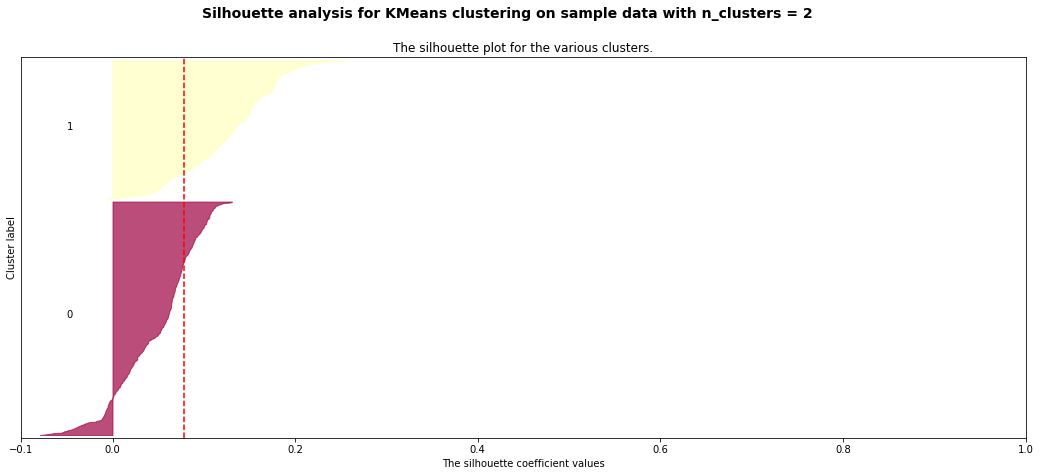

For n_clusters = 3 The average silhouette_score is : 0.041699631962609146


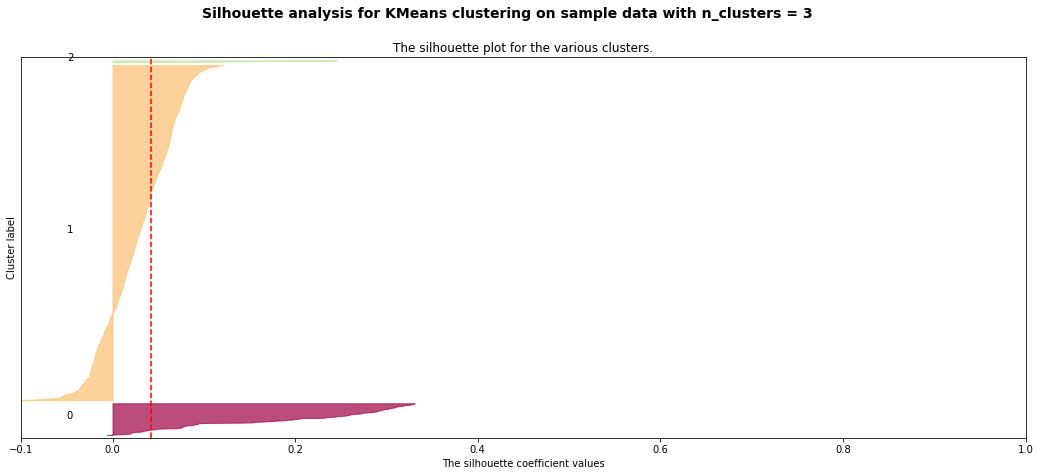

For n_clusters = 4 The average silhouette_score is : 0.08030634830721045


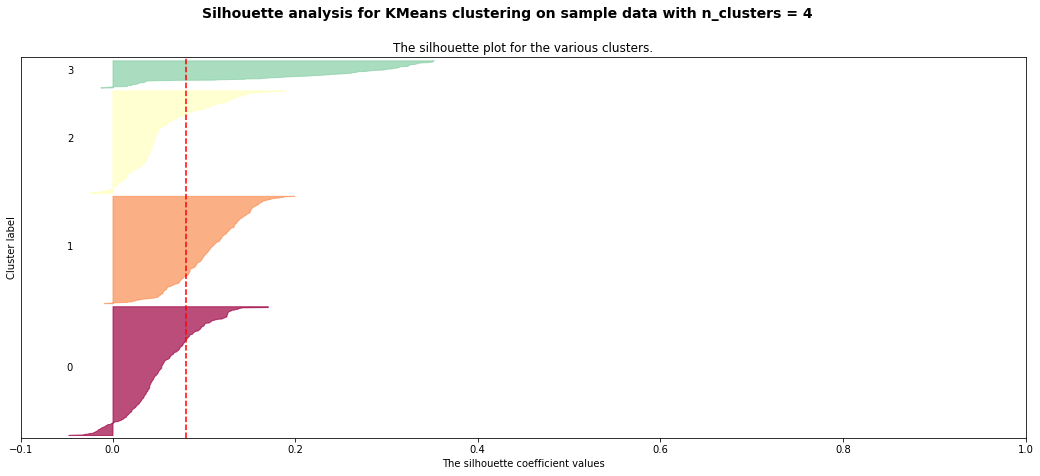

For n_clusters = 5 The average silhouette_score is : 0.08289490645641483


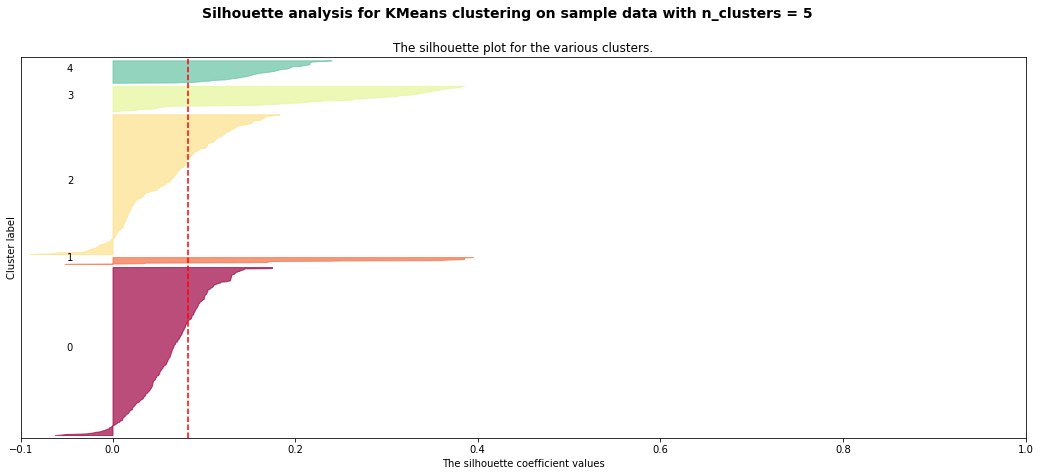

For n_clusters = 6 The average silhouette_score is : 0.09914104209163473


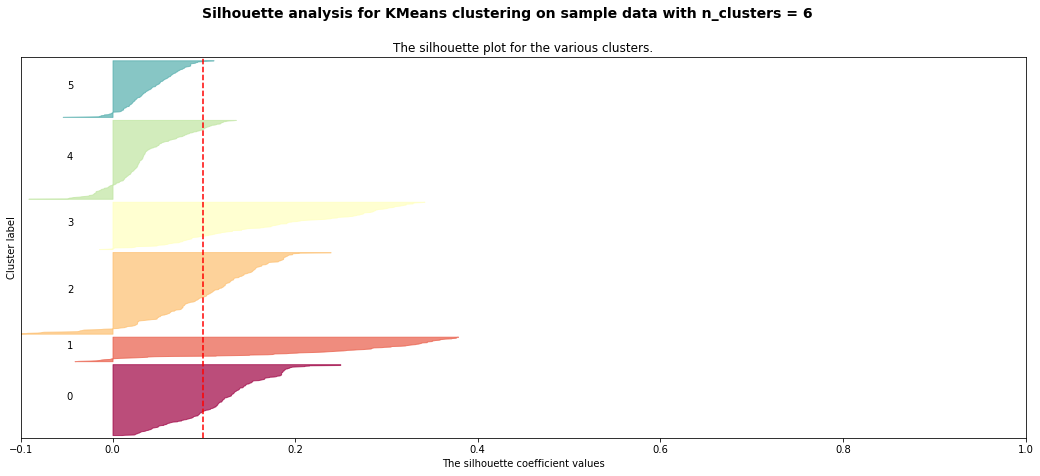

For n_clusters = 7 The average silhouette_score is : 0.07347256632912255


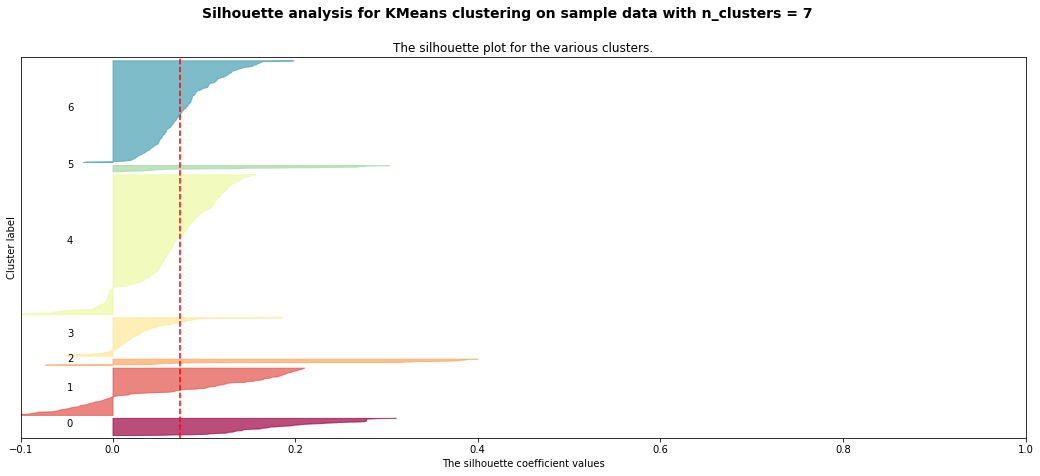

For n_clusters = 8 The average silhouette_score is : 0.072707682840682


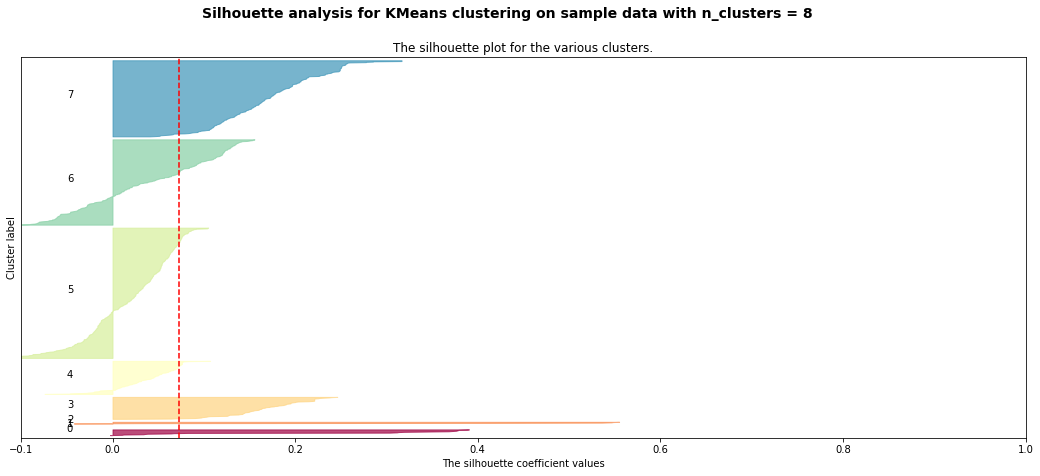

For n_clusters = 9 The average silhouette_score is : 0.09449131273106254


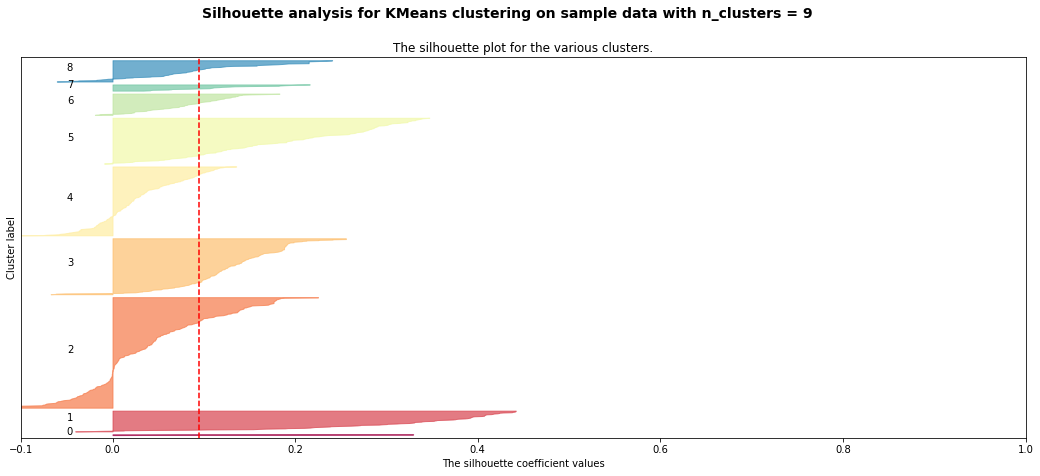

For n_clusters = 10 The average silhouette_score is : 0.06249361672425682


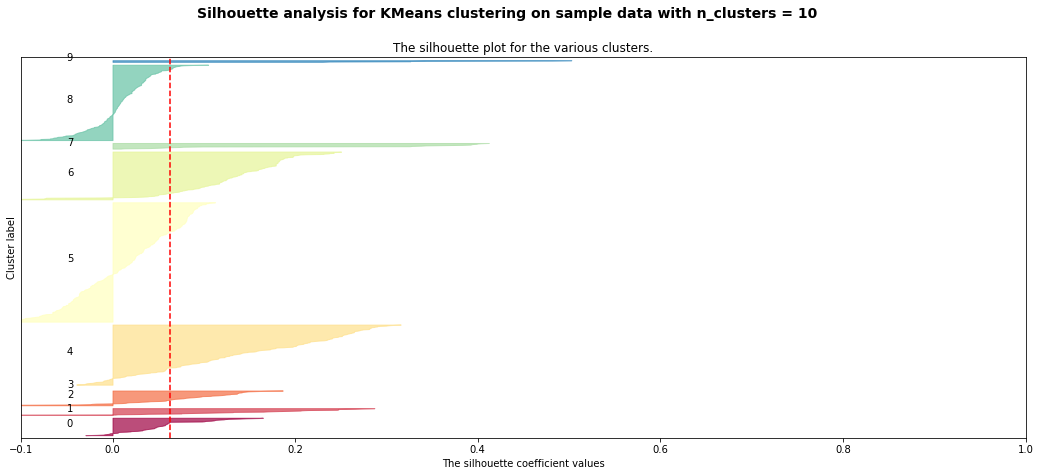

For n_clusters = 11 The average silhouette_score is : 0.0738394505483264


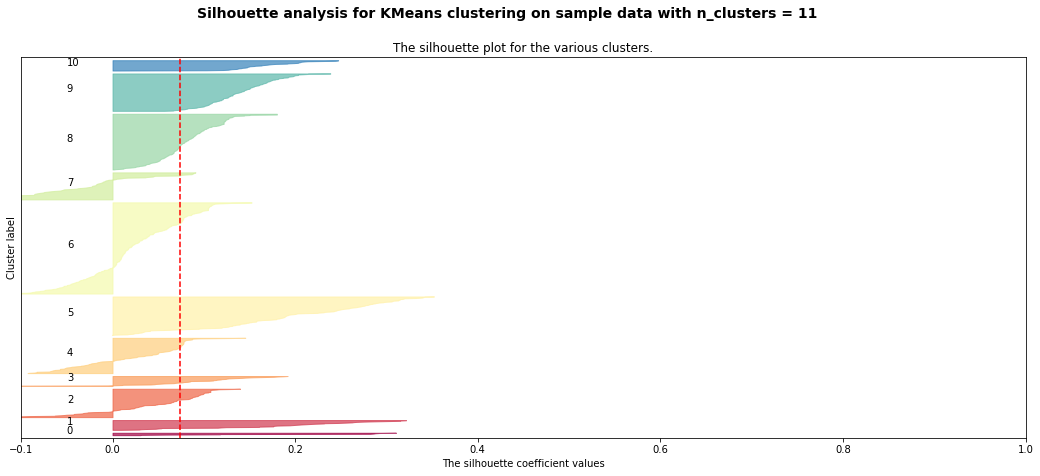

For n_clusters = 12 The average silhouette_score is : 0.08928245699503597


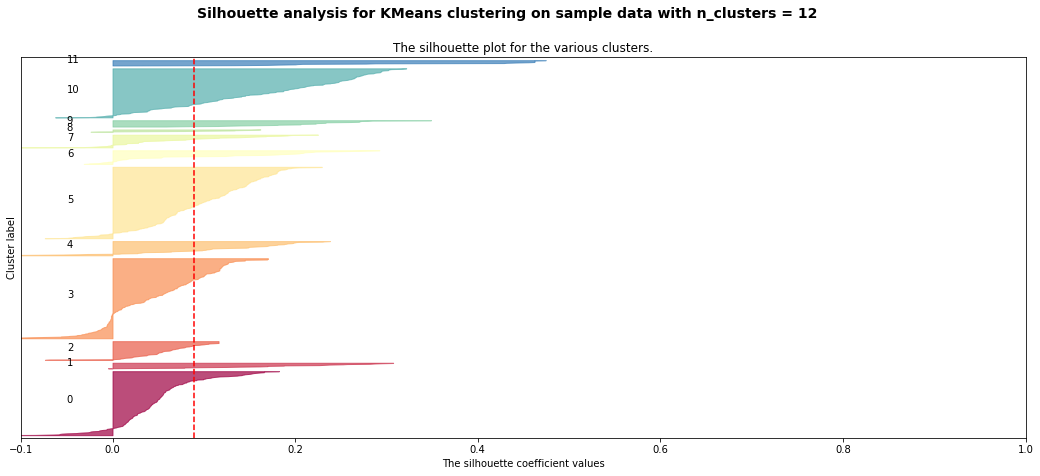

For n_clusters = 13 The average silhouette_score is : 0.10229974427560738


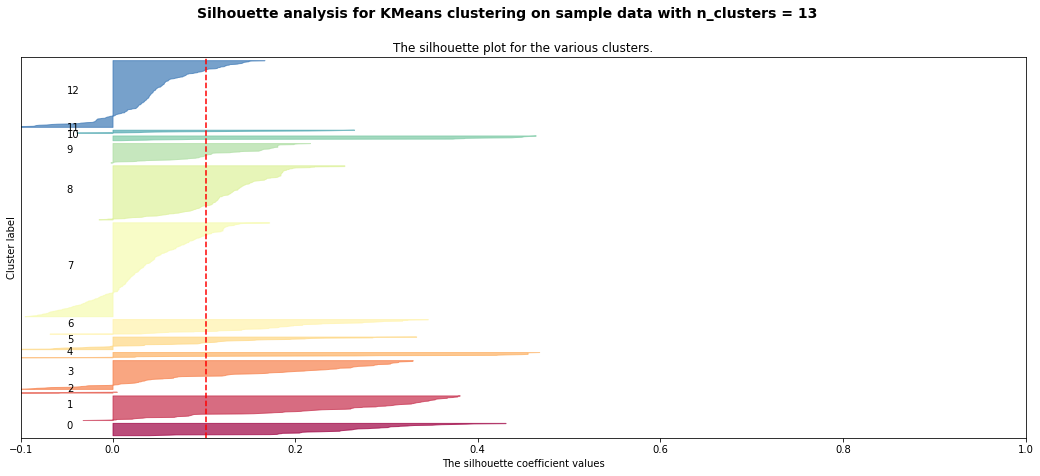

For n_clusters = 14 The average silhouette_score is : 0.0575555607648803


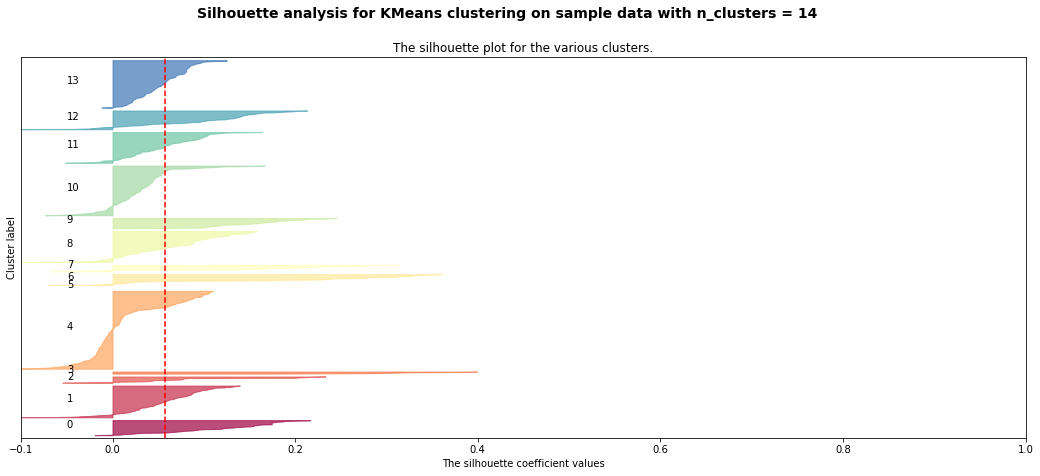

For n_clusters = 15 The average silhouette_score is : 0.07398448539009454


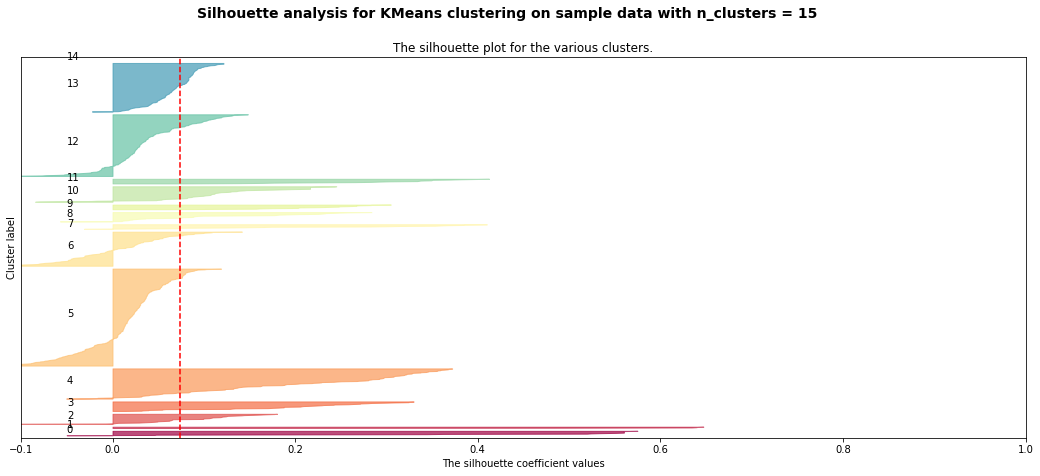

In [16]:
#model = Word2Vec(list(cluster_0['header']), min_count=1)
#X = model[model.wv.vocab]
for n_clusters in range(2,16):
    fig, (ax1) = plt.subplots()
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    M, C = kMedoids(X, n_clusters)
    
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)

    cluster_labels=np.zeros(X.shape[0])
    for label in C:
        for point_idx in C[label]:
            cluster_labels[point_idx]=label
            
    silhouette_avg = silhouette_score(X, cluster_labels, metric="precomputed")
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric="precomputed")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color =  plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Silhouete score has negative correlations for some clusters, that implies that some elements could correspond to more than one cluster and there is no a considerable distance between clusters. 

To solve the correspondency I apply Hierarchical aclgorithm and chose ward metric. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


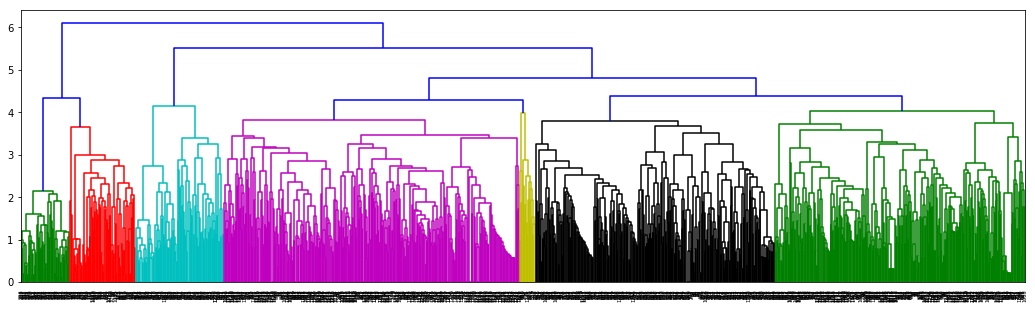

In [17]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'average')
fig=plt.figure()
fig.set_size_inches(18, 5)
dn = hierarchy.dendrogram(Z)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


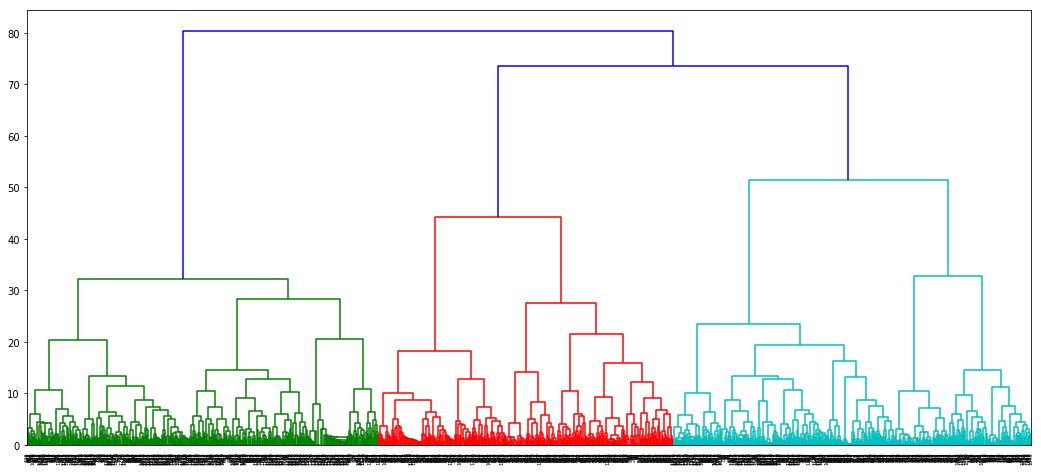

In [18]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X, 'ward')
fig=plt.figure()
fig.set_size_inches(18, 8)
dn = hierarchy.dendrogram(Z)

The number of clusters will depend on we trucate the dendogram.

In [19]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

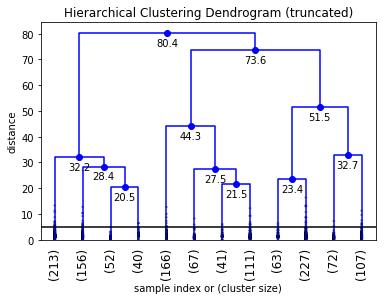

In [20]:
from scipy.cluster.hierarchy import dendrogram
max_d=5
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [21]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')
n_clusters=np.unique(clusters)
print(n_clusters)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]


In [22]:
# Asign the cluster to each table.

cluster_0["num_cluster"]=0
for i in range(len(clusters)):
    cluster_0.loc[i,"num_cluster"]=clusters[i]
cluster_0.head()

,index,cluster,header,count,num_cluster
0,434469,"['parti', 'vote']","bp,parti,seat,vote,vote,won",1,11
1,434470,"['parti', 'vote']","chang,candid,parti,seat,seatschang,vote",4,34
2,434471,"['parti', 'vote']","chang,contestinglist,parti,seat,seatschang,vote",15,11
3,434472,"['parti', 'vote']","chang,lost deposit,parti,seat,seat contest,se...",1,9
4,434473,"['parti', 'vote']","chang,parti,seat,seatschang,turnout,vote",4,11


In [23]:
# Count number of tables by cluster
cluster_0_new=pd.DataFrame({'count' : cluster_0.groupby(['num_cluster']).size()}).reset_index()
cluster_0_new.sort_values("count", ascending=False).head()

,num_cluster,count
31,32,41
38,39,36
86,87,28
47,48,26
16,17,25


In [24]:
# Selecta cluster to evaluate.
cluster_0[cluster_0["num_cluster"]==49]

,index,cluster,header,count,num_cluster
428,434897,"['parti', 'vote']","candid,elector,elector divi,major,parti,sit,to...",1,49
453,434922,"['parti', 'vote']","candid,expenditur,parti,total reject ballot,to...",4,49
505,434974,"['parti', 'vote']","candid,inform vot,major,parti,regist elector,t...",8,49
514,434983,"['parti', 'vote']","candid,inform vot,parti,regist elector,total v...",2,49
515,434984,"['parti', 'vote']","candid,inform vot,parti,regist elector,total v...",1,49
543,435012,"['parti', 'vote']","candid,major,parti,regist elector,reject ballo...",1,49
544,435013,"['parti', 'vote']","candid,major,parti,regist elector,reject ballo...",78,49
546,435015,"['parti', 'vote']","candid,major,parti,regist elector,reject ballo...",1,49
547,435016,"['parti', 'vote']","candid,major,parti,regist elector,reject ballo...",3,49
554,435023,"['parti', 'vote']","candid,major,parti,reject ballot,total formal ...",1,49


Hierarchical clustering got good results. Alhought it requieres specify the distance to truncate dendogram. 

### Using HDBSCAN

In [25]:
import hdbscan
from numpy import isnan
res = pairwise_distances(dtm, metric = "jaccard", n_jobs=4)    
distance = pd.DataFrame(res, index=np.arange(dtm.shape[0]), columns= np.arange(dtm.shape[0]))
where_are_NaNs = isnan(distance)
distance[where_are_NaNs] = 0.0

/home/jhomara/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [26]:
clusterer = hdbscan.HDBSCAN(metric="precomputed",  min_samples=2, min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(distance)

clusters={}
csv=""
for i, label in enumerate(clusterer.labels_):
    #if label!=-1:
        if clusters.get(label)==None:
            clusters[label]=1
            csv=csv+str(label)+"\t"+cluster_0.iloc[i]['header']+"\n"
        else:
            clusters[label]=clusters.get(label)+1
            csv=csv+str(label)+"\t"+cluster_0.iloc[i]['header']+"\n"
            
csv_file = open("clusters_hd.csv", "w")
csv_file.write(csv)
csv_file.close()

In [27]:
df_cluster_hd=pd.read_csv('clusters_hd.csv', sep='\t', names=['cluster','header'])
df_cluster_hd.sort_values("cluster").head()

,cluster,header
306,-1,"candid,date,elect,jun 11 2013,nov 2 1993,nov 2..."
1036,-1,"elect,parti,vote"
192,-1,"bru,fla,main candid,main ideolog,parti,seat,to..."
193,-1,"brčko,constitu,council,mayor,mayorelect by cou..."
195,-1,"by elig vot,of vote cast,parti,seat,vote"


In [28]:
df_cluster_hd_count=pd.DataFrame({'count' : df_cluster_hd.groupby(['cluster']).size()}).reset_index()
df_cluster_hd_count.sort_values("count", ascending=False).head()

,cluster,count
0,-1,253
69,68,45
176,175,41
95,94,17
20,19,17


With this algorithm it is possible split the super-cluster in smaller, but there are a lot of elements tagged as noise, that we have to evaluate. 

### Other alternative: Enrich data

Add information about types of entities found on title of each article. 
I added a new column to initial file with a list of entitie's types. Althought I observed that there are not information about some articles and also there are diferences between types of tables that have the same header.

In [29]:
df_c0_enriched = pd.read_csv("tesis/lattice/cluster0_enriched.csv", sep="\t", 
                             names=["id_table1","pair","cant_total", "id_table2", "id_file","file_name", "title", "id_table3", "header1", "header","title_type"],
                             index_col=False,skiprows=[0] )

In [30]:
df_c0_enriched.head()

,id_table1,pair,cant_total,id_table2,id_file,file_name,title,id_table3,header1,header,title_type
0,2100223,"['parti', 'vote']",239157,426998.11,426998,Fernie (electoral district).html.bz2,Fernie (electoral district),426998.11,"%,100 00%,3 171,71,candidate,expenditures,part...","candid,expenditur,numericheader,parti,total re...",None
1,2100224,"['parti', 'vote']",239157,426998.12,426998,Fernie (electoral district).html.bz2,Fernie (electoral district),426998.12,"%,100 00%,29,3 220,candidate,expenditures,part...","candid,expenditur,numericheader,parti,total re...",None
2,2100225,"['parti', 'vote']",239157,427009.20,427009,City One (constituency).html.bz2,City One (constituency),427009.20,"%,candidate,party,swing,votes,±","candid,parti,swing,vote",None
3,2100226,"['parti', 'vote']",239157,427009.30,427009,City One (constituency).html.bz2,City One (constituency),427009.30,"%,candidate,party,swing,votes,±","candid,parti,swing,vote",None
4,2100227,"['parti', 'vote']",239157,426998.13,426998,Fernie (electoral district).html.bz2,Fernie (electoral district),426998.13,"%,10,100 00%,3 049,candidate,expenditures,part...","candid,expenditur,numericheader,parti,total re...",None


In [31]:
df_c0_enriched_g=pd.DataFrame({'count' : df_c0_enriched.groupby(['pair','header','title_type']).size()}).reset_index()
df_c0_enriched_g.head()

,pair,header,title_type,count
0,"['parti', 'vote']","chang,parti,seat,seatschang,turnout,vote","['Agent', 'Country', 'Election', 'Event', 'Loc...",1
1,"['parti', 'vote']","no,candid,no,parti,seat,vote","['AdministrativeRegion', 'Agent', 'Legislature...",1
2,"['parti', 'vote']","pp,constitu,no parti list,no smc,parti,pr,sea...","['Agent', 'Legislature', 'Organisation']",1
3,"['parti', 'vote']","pp,parti,seat,total,vote,vote,won","['Agent', 'City', 'Legislature', 'Location', '...",1
4,"['parti', 'vote']","vote,parti,seat,vote","['City', 'Location', 'Place', 'PopulatedPlace'...",1


### Another alternative (3-grams)

For each 2-gram clusters we can generated sub-clusters getting 3-grams vectors, using the code proposed. 

In [32]:
df3_c0 = pd.read_csv("tesis/lattice/cluster_file_c.csv", sep="\t", names=["cluster","num","id_table1","pair","cant_total", "id_table2", "id_file","file_name", "title", "id_table3", "header1", "header"], index_col=False )

In [33]:
df3_c0.head()

,cluster,num,id_table1,pair,cant_total,id_table2,id_file,file_name,title,id_table3,header1,header
0,"['vote', 'x jihlava', 'xi brno']",1,669500.14,"['parti', 'vote']",239157,669500.14,669500,Czechoslovak parliamentary election%2C 1929.ht...,"Czechoslovak parliamentary election, 1929",669500.14,"%,party,votes,x jihlava,xi brno,xiii uherské h...","parti,vote,x jihlava,xi brno,xiii uherské hrad..."
1,"['mandat', 'parti', 'vote']",2,1021891.20,"['parti', 'vote']",239157,1021891.20,1021891,Gallneukirchen.html.bz2,Gallneukirchen,1021891.20,"%,mandate,party,votes","mandat,parti,vote"
2,"['mandat', 'parti', 'vote']",2,1037724.20,"['parti', 'vote']",239157,1037724.20,1037724,Politics of Crimea.html.bz2,Politics of Crimea,1037724.20,"%,mandates,parties,votes","mandat,parti,vote"
3,"['parti', 'percent', 'vote']",55,441411.30,"['parti', 'vote']",239157,441411.30,441411,Inder%C3%B8y.html.bz2,Inderøy,441411.30,"members of theexecutive board,party,percent,se...","member of theexecut board,parti,percent,seat i..."
4,"['parti', 'percent', 'vote']",55,759906.40,"['parti', 'vote']",239157,759906.40,759906,Wisconsin Senate recall elections%2C 2012.html...,"Wisconsin Senate recall elections, 2012",759906.40,"date,dist,incumbent,party,percent,votes","date,dist,incumb,parti,percent,vote"


Group data by 3-gram and header to count.

In [34]:
df3_c0_g=pd.DataFrame({'count' : df3_c0.groupby(['cluster','header']).size()}).reset_index()
df3_c0_g.head()

,cluster,header,count
0,"['across depart', 'parti', 'vote']","across depart,parti,vote",1
1,"['after', 'befor', 'vote']","candid,parti,total vot,turnout,vote",16
2,"['after', 'parti', 'vote']","candid,parti,total vot,turnout,vote",1
3,"['allianc', 'parti', 'vote']","abbr,allianc,parti,vote",2
4,"['allianc', 'parti', 'vote']","allianc,constitu,loser,n ,parti,vote,winner",2


In [35]:
df3_count=pd.DataFrame({'count1' : df3_c0.groupby(['cluster']).size()}).reset_index()
df3_count.head()

,cluster,count1
0,"['across depart', 'parti', 'vote']",1
1,"['after', 'befor', 'vote']",16
2,"['after', 'parti', 'vote']",1
3,"['allianc', 'parti', 'vote']",7
4,"['alloc ward', 'parti', 'vote']",2


In [36]:
df3_count['cluster_num']=df3_count.index
df3_count.head()

,cluster,count1,cluster_num
0,"['across depart', 'parti', 'vote']",1,0
1,"['after', 'befor', 'vote']",16,1
2,"['after', 'parti', 'vote']",1,2
3,"['allianc', 'parti', 'vote']",7,3
4,"['alloc ward', 'parti', 'vote']",2,4


In [37]:
cols = ['cluster']
c0=df3_c0_g.join(df3_count.set_index(cols), on=cols)
c0.head()

,cluster,header,count,count1,cluster_num
0,"['across depart', 'parti', 'vote']","across depart,parti,vote",1,1,0
1,"['after', 'befor', 'vote']","candid,parti,total vot,turnout,vote",16,16,1
2,"['after', 'parti', 'vote']","candid,parti,total vot,turnout,vote",1,1,2
3,"['allianc', 'parti', 'vote']","abbr,allianc,parti,vote",2,7,3
4,"['allianc', 'parti', 'vote']","allianc,constitu,loser,n ,parti,vote,winner",2,7,3


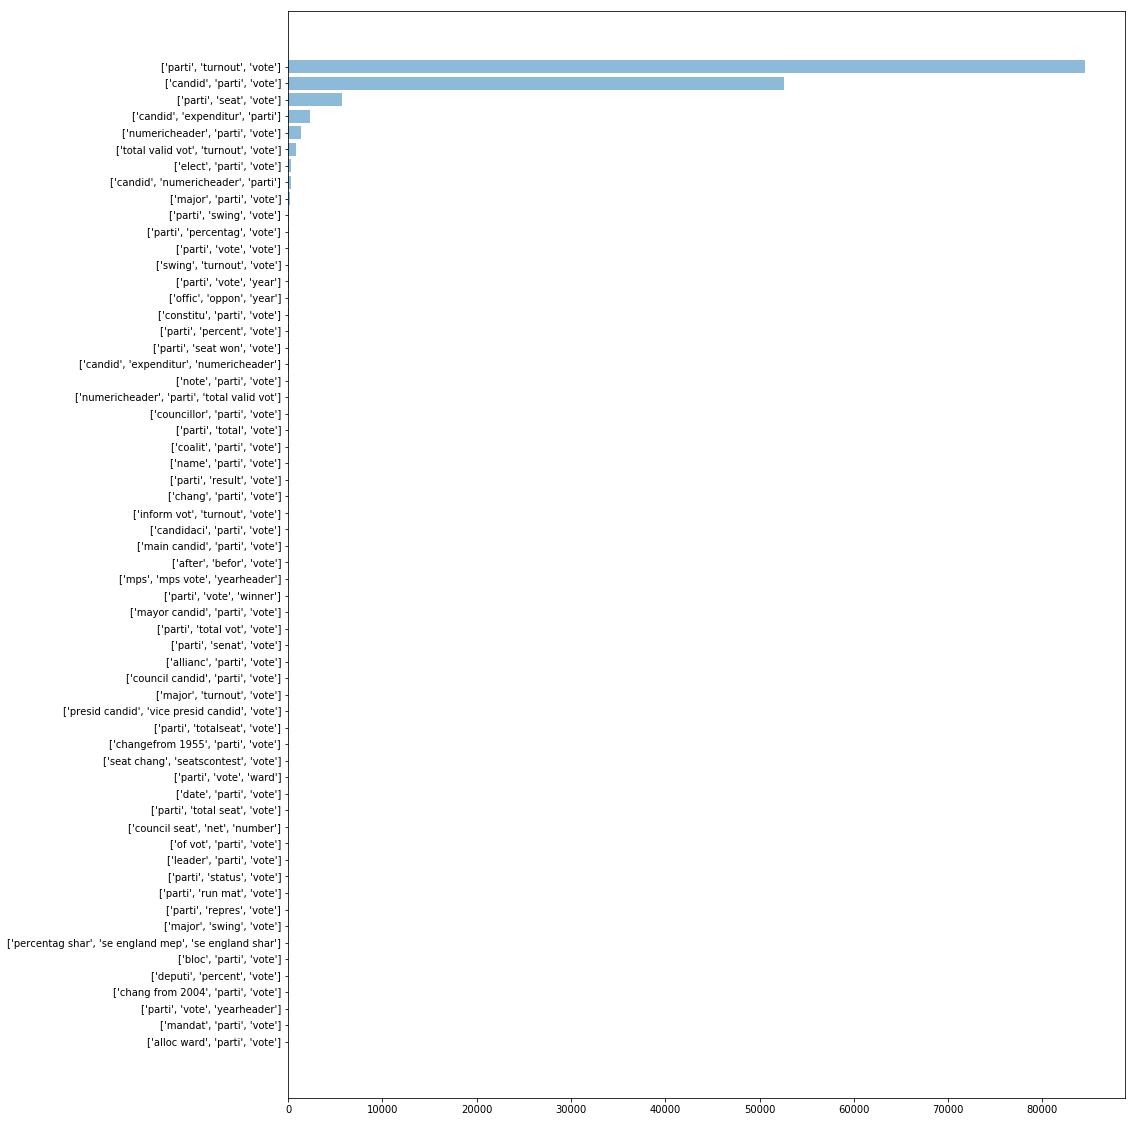

In [38]:
df3_count=df3_count[df3_count["count1"]>1].sort_values("count1", ascending=True)
label=df3_count.cluster.tolist()
y_pos = np.arange(len(label))
y_val=df3_count.count1.tolist()
fig=plt.figure()
fig.set_size_inches(15, 20)
plt.barh(y_pos, y_val, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

The most common 3-grams are [parti, turnout, vote] and [candid, parti, vote]. We could consider the most representative clusters of each pair of headers and extract relations of its tables information. 